# Chromatograpy

In this repository we will explore educational simulations of chromatographic processes.
We will start particularly simple and simulate the chromatographic process with the cell model.
By the way, the repository name is not a typo. Rather, it is a blend of the term "chromatography" and the fact that the code is written in Python (in .py files).

## Cell Model

We imagine the stationary (i.e. the column) and the mobile phase to consist of cells.
Each cell of the stationary phase is in contact with one cell from the mobile phase.
We distribute the molecules between the stationary and mobile phase according to the equilibrium constant.
When this is done, we move the mobile phase cells 'down one cell' such that they are in contact with the next
cell of the stationary phase. Note: we use zero-based indexing for the cells (as does Python), so the first cell is cell 0.

![Cell Model](./img/cell-model.jpg)

## Equilibrium

The molecules will partition between their bound and free state according to an equilibrium constant $K$.
Since we will assume all the cells to be the same size (i.e. have the same volume) we can calculate with
amounts of molecules directly and do not need to bother with concentrations.

$$K = \frac{c_{bound}}{c_{free}} = \frac{n_{bound}/V_{cell}}{n_{free}/V_{cell}} = \frac{n_{bound}}{n_{free}}$$

Computationally, it is much easier to reformulate the equilibrium constant as a fraction of bound molecules give the total number of molecules.

$$f_{bound} = \frac{K}{1 + K} \cdot n_{total}$$

The number of free molecules is then simply $n_{free} = n_{total} - n_{bound}$.

## Setup

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Single Compound

(0.0, 1000.0)

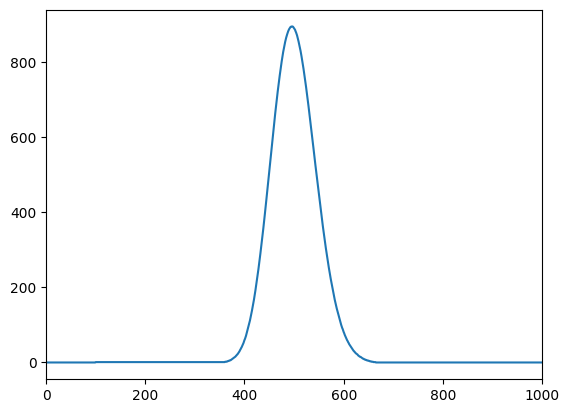

In [10]:
# Define parameters
n_cells = 100
n_steps = 1_000
n_molecules = 100_000
K = 4

# Reformat K to a fractional entity
frac_bound = K / (1 + K)

# Initial state (zero everywhere)
stationary_phase = np.zeros(n_cells)
mobile_phase = np.zeros(n_cells + n_steps)

# Loading of mobile phase in cell just before the stationary phase
mobile_phase[n_cells] = n_molecules

for step in range(1, n_steps + 1):
    # Equilibration
    for cell in range(n_cells):
        n_tot = stationary_phase[cell] + mobile_phase[cell + step]
        n_bound = np.floor(n_tot * frac_bound)
        n_free = n_tot - n_bound
        stationary_phase[cell] = n_bound
        mobile_phase[cell + step] = n_free

plt.plot(mobile_phase)
plt.xlim(0, n_steps)

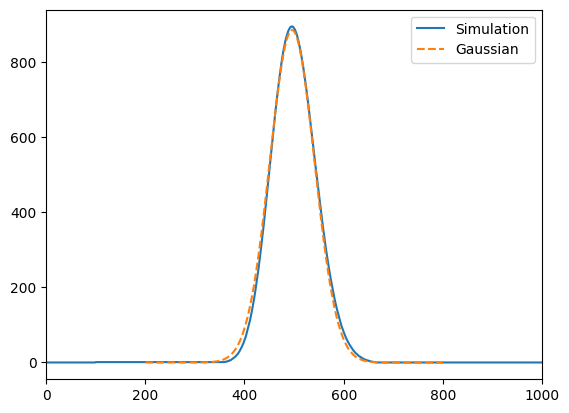

In [11]:
from scipy.stats import norm

x = np.linspace(200, 800, 600)
y = n_molecules * norm.pdf(x, loc=496, scale=45)

plt.plot(mobile_phase, label="Simulation")
plt.plot(x, y, '--', label="Gaussian")
plt.xlim(0, n_steps)
plt.legend()

### Observations

- The simulation yields an almost symmetrical, gaussian-like peak.

## Multiple Compounds

Extending the simulation to multiple compounds is straightforward.
As all compounds are independent of each other, we can simply simulate each compound separately.

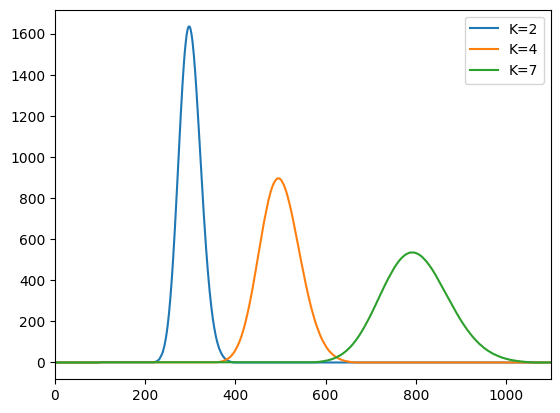

In [12]:
# Define parameters
n_cells = 100
n_steps = 1_100
n_molecules = [100_000, 100_000, 100_000]
K = [2, 4, 7]

# Reformat K to a fractional entity
frac_bound = [k / (1 + k) for k in K]

# Initial state (zero everywhere)
stationary_phase = [np.zeros(n_cells) for _ in K]
mobile_phase = [np.zeros(n_cells + n_steps) for _ in K]

# Loading of mobile phase in cell just before the stationary phase
for compound, n_mol in enumerate(n_molecules):
    mobile_phase[compound][n_cells] = n_mol

for step in range(1, n_steps + 1):
    # Equilibration
    for cell in range(n_cells):
        for compound, frac in enumerate(frac_bound):
            n_tot = stationary_phase[compound][cell] + mobile_phase[compound][cell + step]
            n_bound = np.floor(n_tot * frac)
            n_free = n_tot - n_bound
            stationary_phase[compound][cell] = n_bound
            mobile_phase[compound][cell + step] = n_free

for mp in mobile_phase:
    plt.plot(mp)
plt.xlim(0, n_steps)
plt.legend([f'K={k}' for k in K])

### Observations

- Retention time increases with higher affinity to the stationary phase (column) - as we would expect.
- Peak width increases with increasing retention time.
- Peak height decreases with increasing retention time.
- Overal peak area stays the same (= number of molecules; can be verified by summing over the mobile phases).

For compounds with higher affinity to the stationary phase, we need more cells to transport the compound out of the column because each mobile phase cell will contain fewer molecules than in the case of low-stationary-phase affinity.

### Column Dead Volume

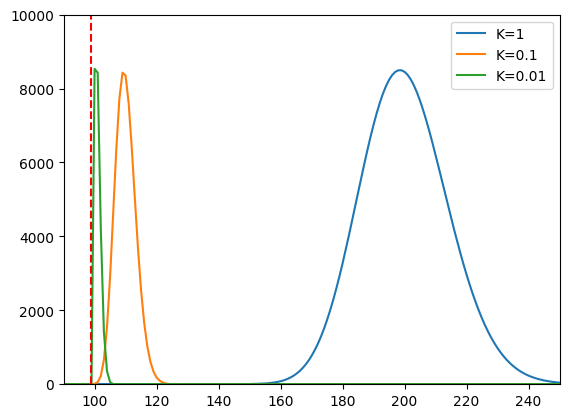

In [13]:
# Define parameters
n_cells = 100
n_steps = 250
n_molecules = [300_000, 70_000, 23_000]
K = [1, 0.1, 1e-2]

# Reformat K to a fractional entity
frac_bound = [k / (1 + k) for k in K]

# Initial state (zero everywhere)
stationary_phase = [np.zeros(n_cells) for _ in K]
mobile_phase = [np.zeros(n_cells + n_steps) for _ in K]

# Loading of mobile phase in cell just before the stationary phase
for compound, n_mol in enumerate(n_molecules):
    mobile_phase[compound][n_cells] = n_mol

for step in range(1, n_steps + 1):
    # Equilibration
    for cell in range(n_cells):
        for compound, frac in enumerate(frac_bound):
            n_tot = stationary_phase[compound][cell] + mobile_phase[compound][cell + step]
            n_bound = np.floor(n_tot * frac)
            n_free = n_tot - n_bound
            stationary_phase[compound][cell] = n_bound
            mobile_phase[compound][cell + step] = n_free

for mp in mobile_phase:
    plt.plot(mp)
plt.vlines([99], 0, 1e4, colors="red", linestyles="dashed")
plt.xlim(90, n_steps)
plt.ylim(-5, 1e4)
plt.legend([f'K={k}' for k in K])

#### Observations

- The lower the affinity to the stationary phase, the earlier the compound elutes.
- There is a lower bound to the retention time, which is given by the number of cells in the column - 'dead volume'.

## Decreasing Binding Affinity with Increasing Bound Molecules

Let's suppose that the binding affinity of the stationary phase decreases with increasing number of bound molecules.
Instead of using a 'hard stop' we will use a model where $K$ decreases exponentially with 

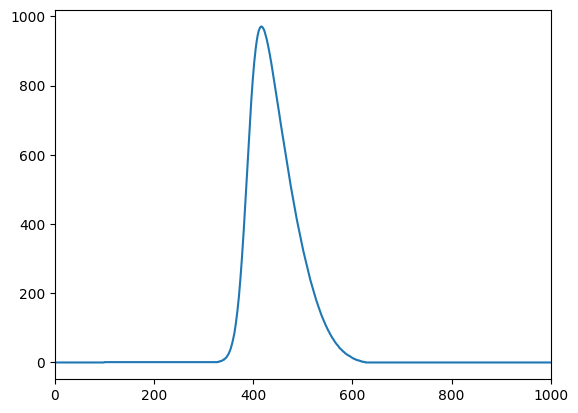

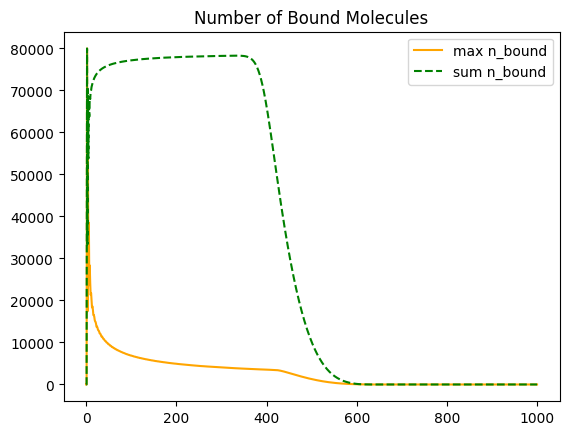

In [17]:
# Define parameters
n_cells = 100
n_steps = 1_000
n_molecules = 100_000
K = 4

def frac_bound(n_bound):
    # Reform K to a fractional entity - now also depending on loading
    k = K * np.exp(-n_bound / 30_000)
    frac_bound = k / (1 + k)
    return frac_bound

# Initial state (zero everywhere)
stationary_phase = np.zeros(n_cells)
mobile_phase = np.zeros(n_cells + n_steps)
max_bound_molecules = np.zeros(n_steps + 1)
sum_bound_molecules = np.zeros(n_steps + 1)

# Loading of mobile phase in cell just before the stationary phase
mobile_phase[n_cells] = n_molecules

for step in range(1, n_steps + 1):
    # Equilibration
    max_bound_molecules[step] = np.max(stationary_phase)
    sum_bound_molecules[step] = np.sum(stationary_phase)
    for cell in range(n_cells):
        n_bound_old = stationary_phase[cell]
        n_tot = n_bound_old + mobile_phase[cell + step]
        n_bound = np.floor(n_tot * frac_bound(n_bound_old))
        n_free = n_tot - n_bound
        stationary_phase[cell] = n_bound
        mobile_phase[cell + step] = n_free

plt.plot(mobile_phase)
plt.xlim(0, n_steps)
plt.show()

# Let's also have a look at the maximum number of bound molecules
plt.plot(max_bound_molecules, color="orange")
plt.plot(sum_bound_molecules, color="green", linestyle="dashed")
plt.title("Number of Bound Molecules")
plt.legend(["max n_bound", "sum n_bound"])

### Observations

- Decreasing binding affinity leads to a tailing peak.
- Due to the way the simulation is run the initial loading of the column is very, very high. Let's look at that in some more detail.

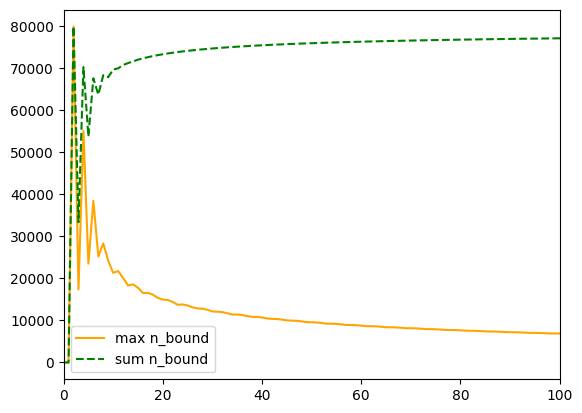

In [18]:
plt.plot(max_bound_molecules, color="orange")
plt.plot(sum_bound_molecules, color="green", linestyle="dashed")
plt.xlim(0, 100)
plt.legend(["max n_bound", "sum n_bound"])

We see the oscillating behaviour at the beginning. First there are no bound molecules so $f_{bound}$ is high (0.8). In the next step the affinity is starkly decreased due to the high number of bound molecules. This is an issue in our model but does not affect the qualitative result. We can smooth this behaviour out a bit in a further iteration of the model.

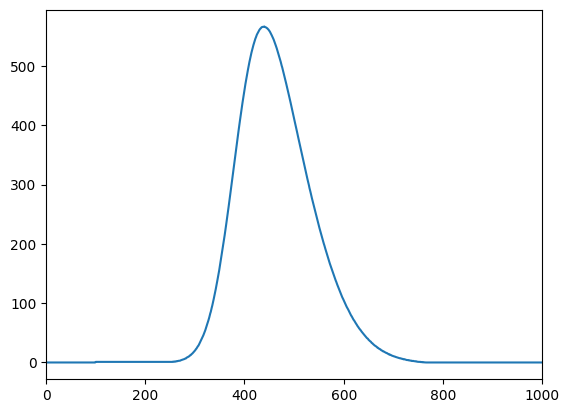

(0.0, 100.0)

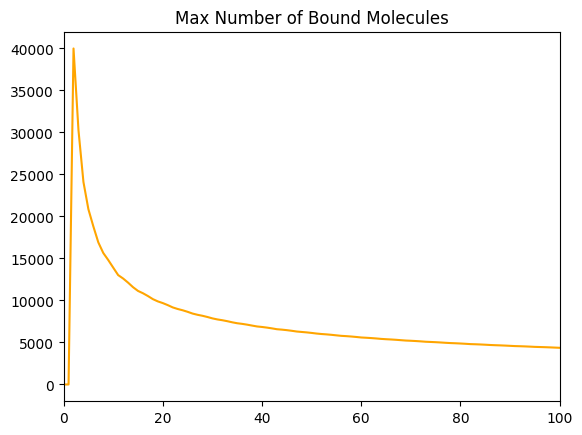

In [16]:
# Define parameters
n_cells = 100
n_steps = 1_000
n_molecules = 100_000
K = 4

def frac_bound(n_bound):
    # Reform K to a fractional entity - now also depending on loading
    k = K * np.exp(-n_bound / 30_000)
    frac_bound = k / (1 + k)
    return frac_bound

# Initial state (zero everywhere)
stationary_phase = np.zeros(n_cells)
mobile_phase = np.zeros(n_cells + n_steps)
max_bound_molecules = np.zeros(n_steps + 1)

# Loading of mobile phase in cell just before the stationary phase
mobile_phase[n_cells] = n_molecules

for step in range(1, n_steps + 1):
    # Equilibration
    max_bound_molecules[step] = np.max(stationary_phase)
    for cell in range(n_cells):
        n_bound_old = stationary_phase[cell]
        n_tot = n_bound_old + mobile_phase[cell + step]
        # Average fraction of bound molecules with previous step
        n_frac_old = frac_bound(n_bound_old)
        n_bound_new = np.floor(n_tot * n_frac_old)
        n_frac_new = frac_bound(n_bound_new)
        n_bound = (n_bound_old + n_bound_new) / 2
        n_free = n_tot - n_bound
        stationary_phase[cell] = n_bound
        mobile_phase[cell + step] = n_free

plt.plot(mobile_phase)
plt.xlim(0, n_steps)
plt.show()

# Let's also have a look at the maximum number of bound molecules
plt.plot(max_bound_molecules, color="orange")
plt.title("Max Number of Bound Molecules")
plt.xlim(0, 100)